In [169]:
import pandas as pd
import numpy as np
import time

In [170]:
from plotly.offline import iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

---
### Sub：Metrics

In [171]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [172]:
# 列印績效圖表，可以選擇是否儲存
def showPlot(true, prediction, title, sub_title, size='M', save=False):
    size == 'L' and plt.figure(figsize=(28, 10))
    plt.plot(true, color='red', label='Real')
    plt.plot(prediction, color='blue', label='Prediction')
    plt.title('Industry Elec Prediction %s %s t:%d' % (title, sub_title, time))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    save and plt.savefig('Image/%s-%s-%d.png' % (title, sub_title, time))
    plt.show()

---
### Sub：Data Processing

In [173]:
# 資料特徵擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    return data

In [174]:
from sklearn.preprocessing import MinMaxScaler
# 資料正規化與尺度還原
def normalize(data):
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled
def deNormalize(sc, value):
    value_unscaled = value * \
        (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    value_unscaled = value_unscaled.reshape(value_unscaled.shape[0])
    return value_unscaled

In [175]:
# 根據給定的時間範圍自動產生訓練集
def split_train(data, trainFrom, trainTo, pastDay=7, futureDay=7):
    num_train_from = df[df['Date'] == trainFrom].index.item()
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    RawTrain = data[num_train_from:num_train_to]
    print('RawTrain', RawTrain.shape)
    return RawTrain
# 根據給定的時間範圍自動產生測試集
def split_test(data, testFrom, testTo, pastDay=7, futureDay=7):
    num_test_from = df[df['Date'] == testFrom].index.item()
    num_test_to = df[df['Date'] == testTo].index.item() + 1
    RawTest = data[num_test_from-pastDay:num_test_to]
    print('RawTest', RawTest.shape)
    return RawTest
# 拆分訓練與驗證，需要手動切割時才使用
def split_val(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [176]:
# 滾動訓練資料
def buildTrain(train, pastDay, futureDay):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])  # kW
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [177]:
# 滾動測試資料
def buildTest(test, pastDay, futureDay):
    input_set, truth_set = test, test[pastDay:]
    X_test, Y_truth = [], []
    for i in range(0, int((test.shape[0]-pastDay)/futureDay)):
        X_test.append(input_set[futureDay*i:futureDay*i+pastDay])
        Y_truth.append(truth_set[i*futureDay:(i+1)*futureDay, 0])  # kW
    testInput, testTruth = np.array(X_test), np.array(Y_truth)
    testInput = testInput.reshape(testInput.shape[0], testInput.shape[1], testInput.shape[2])
    testTruth = testTruth.reshape(testTruth.shape[0] * testTruth.shape[1])
    print('testInput.shape, testTruth.shape', testInput.shape, testTruth.shape)
    return testInput, testTruth

---
### Sub：Model

In [178]:
# 分配顯存空間，未使用 tensorflow-GPU 可以跳過這段
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.45
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [179]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector, Activation
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [180]:
def buildModel(shape, train_x, train_y):
    epochs, batch_size = 100, 16
    model = Sequential()
    model.add(CuDNNLSTM(units=400, input_shape=(shape[1], shape[2])))
    model.add(Activation('relu'))
    model.add(RepeatVector(7))
    
    model.add(CuDNNLSTM(50, return_sequences=True))
    model.add(Activation('relu'))

    model.add(TimeDistributed(Dense(300, activation='relu')))
    model.add(Flatten())
    model.add(Dense(units=futureDay))
    
    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=15, mode='min', verbose=0)
    earlyStop = EarlyStopping(
        monitor="val_loss", patience=100, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y,
                            epochs=epochs, batch_size=batch_size,
                            verbose=0,
                            validation_split=0.1,
                            callbacks=[reduce_lr, earlyStop])
    return model, modelResult

In [181]:
def model_forecast(model, input_data):
    forecast_temp = model.predict(input_data)
    forecast = forecast_temp.reshape(
        forecast_temp.shape[0] * forecast_temp.shape[1])
    return forecast

In [182]:
def model_evaluate(model, sc, truth, input_set):
    truth = pd.DataFrame(truth)
    truth = deNormalize(sc, truth.values)
    predict = model_forecast(model, input_set)
    predict = deNormalize(sc, predict)
    return predict

---
### Main

In [183]:
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1369, 12)

In [184]:
features = [
    'kW',
    'PeakLoad(MW)_shift7',
    'isHoliday_shift7',
    'dayOfYear',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7',
]

In [185]:
# 預測時間
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'
# 步數選擇
pastDay = 7
futureDay = 7

In [186]:
# 特徵選取
RawData = augFeatures(df, features)

# 正規化
sc, RawData = normalize(RawData)

# 資料範圍選取
RawTrain = split_train(RawData, trainFrom, trainTo, pastDay, futureDay)
RawSelf = split_test(RawData, '2017-01-11', '2019-01-01', pastDay, futureDay)
RawTest = split_test(RawData, testFrom, testTo, pastDay, futureDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, pastDay, futureDay)
selfInput, selfTruth = buildTest(RawSelf.values, pastDay, futureDay)
testInput, testTruth = buildTest(RawTest.values, pastDay, futureDay)

# 驗證資料
# X, Y, Xv, Yv= split_val(X_train, Y_train, 0.1)

RawTrain (728, 6)
RawTest (728, 6)
RawTest (273, 6)
X_train.shape, Y_train.shape (714, 7, 6) (714, 7)
testInput.shape, testTruth.shape (103, 7, 6) (721,)
testInput.shape, testTruth.shape (38, 7, 6) (266,)


In [187]:
%%time
total_self = []
total_test = []
model_save= []

# 為求公平衡量模型，執行 n次
for i in range(10):
    print("round: ", str(i))
    model, modelResult = buildModel(X_train.shape, X_train, Y_train)
    model_save.append(model) # 儲存 model 供未來使用
    self_predict = model_evaluate(model, sc, selfTruth, selfInput)
    test_predict = model_evaluate(model, sc, testTruth, testInput)
    total_self.append(self_predict.reshape(self_predict.shape[0]))
    total_test.append(test_predict.reshape(test_predict.shape[0]))

# 平均處理 n個模型的預測結果
mean_self = np.array(total_self).mean(axis=0)
mean_test = np.array(total_test).mean(axis=0)

round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
Wall time: 14min 5s


---
## Log Setting
##### ( 設定本次實驗的戳記代碼 )

In [188]:
time = 2
save = True
# save = False
model_name = '(Talos_LSTM_7)'

---
## Self Prediction
##### ( 使用訓練資料進行預測，檢查是否過度學習 )

RMSE 4.004384483131884
MAPE 0.879631248271163


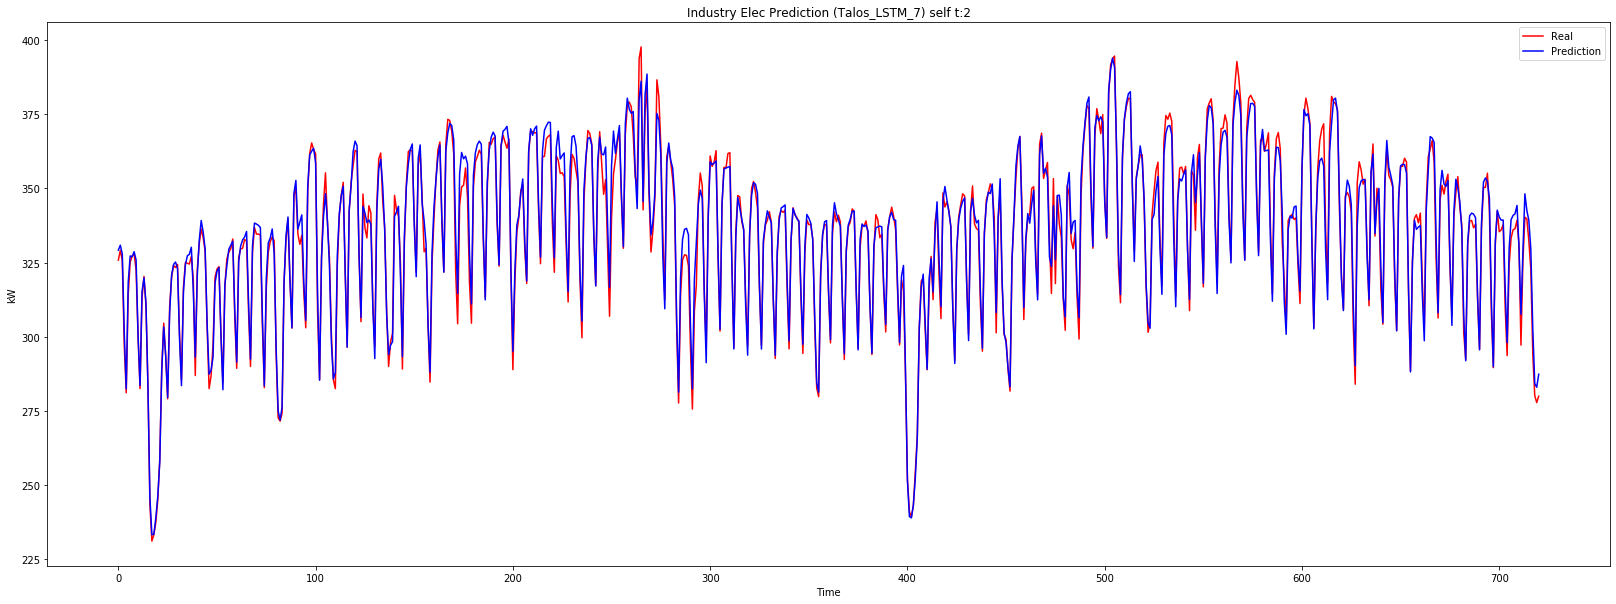

In [189]:
# 自我測試
self_trurh = pd.DataFrame(selfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
calcError(self_trurh, mean_self)
showPlot(self_trurh, mean_self, model_name, "self", size="L", save=save)

---
## Test Prediction

RMSE 8.896489304028561
MAPE 1.924515683370752


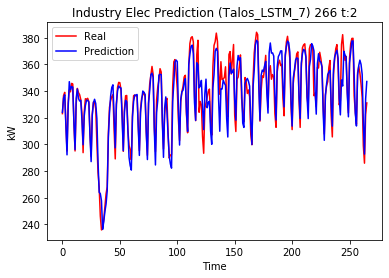

In [190]:
# 實際測試
test_trurh = pd.DataFrame(testTruth)
test_trurh = deNormalize(sc, test_trurh.values)
calcError(test_trurh, mean_test)
showPlot(test_trurh, mean_test, model_name, str(len(testTruth)), save=save)

---
## 特殊日替換

In [191]:
# 建構物件
d = {'date': pd.date_range(start = testFrom, end = testTo),
     'truth': test_trurh,
     'rowsMean': mean_test}
df_predict = pd.DataFrame(d)
df_predict.shape

(266, 3)

In [192]:
# 定義特殊日
_0202_0210 = (df_predict['date'] >='2019-02-02') & (df_predict['date'] <= '2019-02-10')
_0228_0303 = (df_predict['date'] >='2019-02-28') & (df_predict['date'] <= '2019-03-03')
_0404_0407 = (df_predict['date'] >='2019-04-04') & (df_predict['date'] <= '2019-04-07')
_0501 = (df_predict['date'] >='2019-05-01') & (df_predict['date'] <= '2019-05-01')
_0607_0609 = (df_predict['date'] >= '2019-06-07') & (df_predict['date'] <= '2019-06-09')
_0913_0915 = (df_predict['date'] >= '2019-09-13') & (df_predict['date'] <= '2019-09-15')

holidays = ['春節', '228假期', '清明假期', '勞動節', '端午假期', '中秋假期']
holiday_range = [_0202_0210, _0228_0303, _0404_0407, _0501, _0607_0609, _0913_0915]
holiday_len = [9, 4, 4, 1, 3, 3]
holiday_range_fall = [{'from': '2019-02-02',
                       'to': '2019-02-15'},
                      {'from': '2019-02-28',
                       'to': '2019-03-07'},
                      {'from': '2019-04-04',
                       'to': '2019-04-11'},
                      {'from': '2019-05-01',
                       'to': '2019-05-08'},
                      {'from': '2019-06-07',
                       'to': '2019-06-14'},
                      {'from': '2019-09-13',
                       'to': '2019-09-20'}]

In [193]:
# 觀察特殊日績效
for i in range(len(holidays)):
    df_temp = df_predict[holiday_range[i]]
    print("%s %d days"%(holidays[i] ,len(df_temp)))
    calcError(df_temp['truth'], df_temp['rowsMean'])

print("沒有排除特殊日（原始績效）")
calcError(df_predict['truth'], df_predict['rowsMean'])

print("排除所有特殊日")
excludeHolidays = ~_0202_0210 & ~_0228_0303 & ~_0404_0407 & ~_0501 & ~_0607_0609 & ~_0913_0915
df_excludeHolidays = df_predict[excludeHolidays]
calcError(df_excludeHolidays['truth'], df_excludeHolidays['rowsMean'])

春節 9 days
RMSE 10.156075078087039
MAPE 3.00219120216222
228假期 4 days
RMSE 8.381163562231375
MAPE 2.436007663299042
清明假期 4 days
RMSE 6.237527780550981
MAPE 1.707956764966883
勞動節 1 days
RMSE 18.30053613281251
MAPE 5.646588274821123
端午假期 3 days
RMSE 7.10224940844187
MAPE 2.1030626966212758
中秋假期 3 days
RMSE 9.55628615773882
MAPE 1.8828341414949206
沒有排除特殊日（原始績效）
RMSE 8.896489304028561
MAPE 1.924515683370752
排除所有特殊日
RMSE 8.843946004747155
MAPE 1.8624847704749032


In [194]:
# 替換特殊日
df_update = df_predict

for i in range(len(holidays)):
    print("%s"%(holidays[i]))
    # 選取要重新預測的期間
    tempRaw = split_test(RawData,
                         holiday_range_fall[i].get('from'),
                         holiday_range_fall[i].get('to'),
                         pastDay, futureDay)
    tempInput, tempTruth = buildTest(tempRaw.values, pastDay, futureDay)
    tempPredict = model_evaluate(model, sc, tempTruth, tempInput)
    df_update.at[df_update[holiday_range[i]].index.tolist(),
                 'rowsMean'] = tempPredict[:holiday_len[i]]
    # 計算替換後的績效
    df_temp = df_update[holiday_range[i]]
    calcError(df_temp['truth'], df_temp['rowsMean'])

春節
RawTest (21, 6)
testInput.shape, testTruth.shape (2, 7, 6) (14,)
RMSE 7.791753615617715
MAPE 2.6360479719370016
228假期
RawTest (15, 6)
testInput.shape, testTruth.shape (1, 7, 6) (7,)
RMSE 6.137475288430174
MAPE 1.6325514468743443
清明假期
RawTest (15, 6)
testInput.shape, testTruth.shape (1, 7, 6) (7,)
RMSE 5.915437928837556
MAPE 1.886398728311222
勞動節
RawTest (15, 6)
testInput.shape, testTruth.shape (1, 7, 6) (7,)
RMSE 17.911528564453135
MAPE 5.526560885548285
端午假期
RawTest (15, 6)
testInput.shape, testTruth.shape (1, 7, 6) (7,)
RMSE 5.684060965390143
MAPE 1.4514549617498926
中秋假期
RawTest (15, 6)
testInput.shape, testTruth.shape (1, 7, 6) (7,)
RMSE 11.594580679412006
MAPE 2.3280510914681645


RMSE 8.797261289316861
MAPE 1.8999497216101668


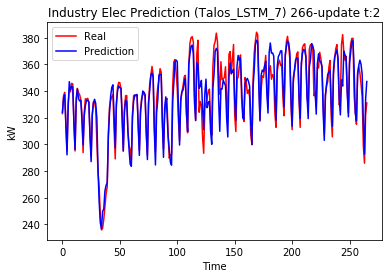

In [195]:
truth = df_update['truth']
pred = df_update['rowsMean']
calcError(truth, pred)
showPlot(truth, pred, model_name, str(len(truth))+'-update', save=save)

---
## Save Model

In [196]:
# import h5py
# Model.save('Model/IndustryElec_cLSTM(7to7)_model_%d.h5'%(time))